# 8. Convolución Rápida

En los capítulos anteriores se estudiaron las técnicas de diseño e implementación de filtros digitales FIR e IIR, empleando algún esquema de implementación orientado a muestras o bloques y alguna estrategia de optimización. En un gran número de aplicaciones, la señal de entrada se trata de un bloque de datos y no de un flujo periódico de muestras, por ejemplo, el tratamiento de un archivo de audio pregrabado. Aunque en estas aplicaciones resulta más práctico el uso de una implementación orientada a bloques para filtros FIR o IIR, el uso de estos filtros no es quizás la forma más eficiente de implementación, en términos computacionales, comparado a técnicas basadas en la Transformada Rápida de Fourier (FFT) que se describirán en este capítulo.

En el capítulo anterior se mostró que el producto de dos espectros DFT corresponde en el tiempo a una **convolución circular**, llamada así porque se asume en forma implícita que las señales convolucionadas son periódicas y con un período igual a $N$ muestras, así mismo, se estableció la condición para la longitud de la FFT

$$N\geq N_{x}+N_{h}-1$$

que permite calcular una convolución lineal por medio de un algoritmo basado en la convolución circular. 

Cuando empleamos FFT para el cálculo de las DFT en el diagrama de bloques de la convolución circular

![Convolución Rápida](../img/cap7_fast_conv.png)

se obtiene el algoritmo denominado **Convolución Rápida**, cuya complejidad computacional es $\mathcal{O}(2Nlog_{2}N+N)$, debido a la presencia de una FFT, una IFFT y $N$ multiplicaciones.

A simple vista no se encontrarían motivos para llamar a este algoritmo rápido, sin embargo, esta denominación solamente es válida para aquellas aplicaciones donde se requiera hacer una convolución a un bloque de datos y no a una muestra en particular. Lo anterior se entiende mejor si comparamos la convolución lineal y la circular. La lineal tiene un costo computacional $\mathcal{O}(N)$ por cada muestra que se procese de la señal de entrada, siendo $N$ la longitud de la respuesta al impulso. De esta forma las implementaciones que hacen uso de la convolución lineal son muy eficientes cuando se emplean en aplicaciones donde se calcula la sumatoria de convolución cada vez que ingrese una muestra, es decir, en aplicaciones de tiempo real donde la respuesta del sistema deba sea menor o igual al período de muestreo, o bien cuando la captura de la muestra se realiza por medio de las técnicas de entrada/salida programada o entrada/salida por interrupción. Sin embargo, si aplicamos el algoritmo de la convolución lineal a un bloque de $N$ datos, el costo computacional de esta convolución sobre el segmento será $\mathcal{O}(N^{2})$, cuyo crecimiento respecto a $N$ es mayor que el de la convolución rápida como se muestra en la siguiente figura.

![Costo Computacional Fastconv](../img/cap8_fftconv_cost.png)

El filtrado de bloques de datos es algo común en el procesamiento digital de señales, ya que en la mayoría de las aplicaciones, las señales se encuentran pregrabadas (aplicaciones _off-line_) o la adquisición de los datos, en una aplicación en tiempo real, se realiza por la técnica de _Acceso Directo a Memoria_ (DMA). En estos casos, la convolución rápida es preferible a la convolución lineal para procesar bloques de datos. 

Sin embargo, la convolución rápida no siempre es la solución más óptima para cualquier tamaño $N$ del bloque de datos como se muestra en la figura de arriba, notándose que para un $N$ pequeño la convolución lineal resulta ser más eficiente que la convolución rápida, sin embargo, el punto de cruce ambas formas de línea depende de la implementación de los algoritmos y del procesador empleado. 

En conclusión, la convolución rápida se debe emplear en aquellas aplicaciones en las cuales:

* Se requiera hacer un filtrado digital a un bloque de datos lo suficientemente grande; para bloques pequeños resulta más conveniente la convolución lineal.

* La adquisición de las señales se realiza por medio de Acceso Directo a Memoria (DMA).

Una ventaja adicional de la convolución rápida se debe a que no es necesario el cálculo de la respuesta al impulso pues el diseño del filtro se puede hacer completamente en el dominio de la frecuencia. Esta característica se aprovecha en diversas aplicaciones en las que la respuesta en frecuencia es variante en el tiempo, por ejemplo, en aplicaciones de reducción de ruido como se verá más adelante.

Hay que recordar que para calcular la convolución rápida, la señal de entrada se debe capturar en bloques de un tamaño menor a la longitud de las FFT ($N$), con el fin de dar validez a la condición de convolución lineal ($N\geq N_{x}+N_{h}-1$), para lo cual se debe rellenar con ceros los datos no capturados en el arreglo de entradas. 

#### Para Reflexionar

En un sistema de reducción de ruido con filtro digital FIR se determinó que la longitud de la respuesta al impulso que más se adaptaba por cuestiones de selectividad era de 4000 datos. Si el sistema trabaja a una frecuencia de muestreo de 48kHz y cada operación MAC (multiplicación-acumulación) tarda $0.5\mu s$. 

* ¿Cuánto tiempo tarda el algoritmo de cálculo del filtro FIR en procesar 10.000 muestras de entrada? 
* ¿Usar este filtro FIR permite hacer los cálculos en tiempo real? 
* ¿Es posible sustituir el filtro FIR por un algoritmo de convolución rápida?

## Ejemplo 8.1 - Parte 1

Establezca un método para implementar un filtro digital FIR que tiene una respuesta al impulso de longitud $N_{h}=100$ y que correrá en un sistema que captura la señal de entrada usando la técnica de DMA.

Para solucionar este problema usaremos un tamaño para la FFT de $N=256$ datos en cuanto a que con este valor podemos cumplir la condición de convolución lineal y además es una longitud potencia de dos. $H[k]$ se calculará entonces usando una FFT de $N=256$ muestras, así que los restantes 156 datos, no existentes en $h[n]$, se deben fijar a ceros. Para la captura de datos por DMA, es necesario adquirir un total de $N_{x}=N-N_{h}+1=157$ muestras, así que el esquema que se usará para la convolución rápida será:

1. Leer 157 muestras por medio de DMA $\rightarrow x[0:156]$

2. Llenar con 99 ceros los elementos no leídos del arreglo de entradas. $0\rightarrow x[157:255]$.

3. Calcular la transformada rápida de Fourier de $x[n]\rightarrow X[k]$.

4. Multiplicar el arreglo $X[k]$ por la respuesta en frecuencia $H[k]$. $X[k]H[k]\rightarrow Y[k]$

5. Calcular la transformada inversa rápida de Fourier de $Y[k]$.

En las siguientes secciones se ilustrará como combinar las IFFT obtenidas para generar la convolución lineal y completar este ejemplo.

## 8.1. Técnicas de Segmentación de la Señal

La convolución rápida implica la partición de la señal de entrada en segmentos de pequeño tamaño $N_{x}$, pero se producen bloques de mayor longitud, $N$, con el fin de satisfacer la condición $N\geq N_{x}+N_{h}-1$. Esto implica que es necesario combinar los resultados individuales de cada convolución rápida para construir la solución correcta de la convolución de longitud $N_{x}$. La forma como se hace esta fusión depende del método empleado para particionar la señal. Al respecto hay dos técnicas básicas: (a) solapamiento y suma; (b) solapamiento y almacenamiento.

### 8.1.1. Solapamiento y suma (_overlap-add_)

La técnica de **solapamiento y suma** u **_overlap-add_** consiste en particionar la señal de entrada en tramos de longitud $N_{x}$ sin traslape entre ellos. Desde el punto de vista de la adquisición de datos por DMA, equivale a capturar bloques de datos de longitud $N_{x}$. El esquema de cálculo de esta técnica se indica en la siguiente figura 

![Esquema de Cálculo Solapamiento y Suma](../img/cap8_overlapadd1.png)

Por cada segmento, se realiza la convolución rápida empleando una longitud de las FFT $N\geq N_{x}+N_{h}-1$, con $N_{h}$ la longitud de la respuesta al impulso. Como la longitud de cada segmento $x_{i}[n]$ de la señal de entrada es $N_{x}$, se hace necesario completarlo con ceros hasta conseguir una longitud $N$ antes de calcular la FFT. 

Paso siguiente, se calcula su FFT, $X_{i}[k]$, y la respectiva convolución rápida con $Y_{i}[k]=X_{i}[k]H[k]$. Posteriormente, se calcula la transformada inversa de Fourier de $Y_{i}[k]$ para obtener $y_{i}[n]$. 

Dado que cada convolución rápida arroja un total de $N$ muestras, se hace necesario sumarle al bloque $y_{i}[n]$, las $N_{h}-1$ muestras no usadas de la pasada convolución rápida (ver figura de arriba), es decir, 

$$\tilde{y}_{i}[n]=\left\{ \begin{array}{cc}
y_{i}[n]+\tilde{y}{}_{i-1}[n+N_{x}] & 0\leq n\leq N_{h}-1\\
y_{i}[n] & N_{h}-1<n<N
\end{array}\right.$$ 

Finalmente, del bloque resultante de la suma, $\tilde{y}_{i}[n]$, se escriben las $N_{x}$ primeras muestras (región sombreada de cada bloque de la figura) al DAC, y las $N_{h}-1$ últimas muestras no usadas se deben almacenar, pues serán sumadas al resultado de la convolución rápida del siguiente segmento de entrada. Nótese que para procesar el primer bloque se hace necesario asumir condiciones iniciales cero. En la siguiente figura se muestra como aplicar este método. 

![Ejemplo Solapamiento y Suma](../img/cap8_overlapadd2.png)

### 8.1.2. Solapamiento y almacenamiento (_overlap-save_)

Por su parte, para el método de **solapamiento y almacenamiento** u **_overlap-save_** la señal de entrada se particiona en segmentos de longitud $N$ que se traslapan entre sí $N_{h}-1$ muestras. Para combinar las soluciones se descartan los $N_{h}-1$ primeros elementos de cada convolución rápida y los restantes elementos se concatenan entre sí asumiendo un desplazamiento de $N-(N_{h}-1)$ muestras para cada bloque de salida. En la siguiente figura se ilustra como aplicar esta técnica. 

![Esquema de Cálculo Solapamiento y Almacenamiento](../img/cap8_overlapsave1.png)

Desde el punto de vista de su implementación sobre un sistema que captura $N_{x}$ datos por DMA, el traslape entre segmentos equivale calcular por cada bloque de entrada $x_{i}[n]$ una FFT de $N$ datos, calculada sobre un bloque que es la concatenación de las $N_{h}-1$ últimas muestras del bloque de entrada pasado, $x_{i-1}[n]$, y las $N_{x}$ muestras del bloque recientemente capturado $x_{i}[n]$ (ver figura de arriba). Es decir, no se completa con ceros sino con muestras de la señal de entrada. De las $N$ muestras que resultan de la convolución rápida se descartan las $N_{h}-1$ primeras muestras y se escriben en el DAC las $N_{x}$ muestras no descartas (región sombreada en cada segmento de la figura anterior). Para procesar el siguiente bloque se hace necesario almacenar las últimas $N_{h}-1$ muestras del bloque de entrada recientemente capturado.

En la siguiente figura se muestra como se aplica este método para una señal particular.

![Ejemplo de Solapamiento y Almacenamiento](../img/cap8_overlapsave2.png)

En conclusión, la técnica de solapamiento y suma se basa en el almacenamiento de las últimas $N_{h}-1$ muestras de la salida (resultado de la convolución), las cuales se suman a las primeras $N_{h}-1$ muestras de la siguiente convolución y para el cálculo la FFT de cada bloque se completa con $N_{h}-1$ ceros a la derecha; a diferencia con la técnica de solapamiento y almacenamiento, en la que se almacenan las últimas $N_{h}-1$ muestras del bloque de entrada, que son usadas para completar por izquierda las $N_{x}$ muestras del siguiente bloque de entrada hasta formar un vector de $N$ datos con el que se calcula la próxima FFT, y de la convolución resultante se descartan las primeras $N_{h}-1$ muestras del bloque de salida.

### Ejemplo 8.1 - Parte 2

A continuación se mostrará como implementar en Python la técnica de **solapamiento y suma** del Ejemplo 8.1. Es importante aclarar que este programa solamente muestra como implementar el algoritmo, pues realmente la función ``lfilter`` de Python puede resultar más eficiente para realizar dicho filtrado en un PC. Sin embargo, el algoritmo sirve como referencia para hacer una implementación en tiempo real para sistemas embebidos.

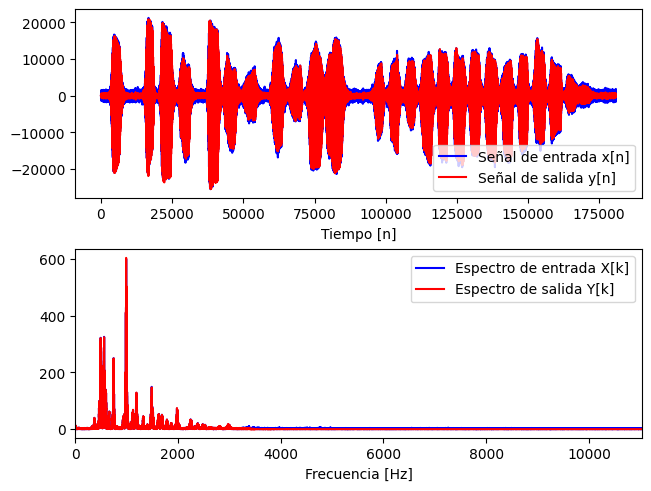

In [1]:
#Ejemplo 8.1. Parte 2. Convolución Rápida usando overlap-add 
#
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, ifft

def fastconv_oadd(x, Hk, Nx, Nfft):
    n = 0 
    y = np.zeros(len(x)) # Condiciones iniciales cero
    while(n+Nfft < len(x)):
        xi = x[n:n+Nx]          # Captura Nx datos    
        Xk = fft(xi, Nfft)      # Completa con ceros     
        Yk = Xk*Hk              # Calcula convolución
        yi = np.real( ifft(Yk) )            
        # Realiza la adición de los bloques     
        y[n:n+Nfft] = y[n:n+Nfft] + yi
        n = n+Nx
    return y

#Carga un archivo externo WAV
fs, xn = wavfile.read('cancion_ruido.wav')

#Configuración de la convolución rápida según Ejemplo 8.1-Parte 1
Nfft = 256
Nx = 157
Nh = 100 

# Crea una respuesta al impulso de Nh datos 
n  = np.arange(-(Nh-1)/2,(Nh-1)/2+1)
hn = 0.15*np.sinc(0.15*n) 

# Calcula la respuesta en frecuencia
Hk = fft(hn, Nfft)

# Realiza la convolución rápida 
y = fastconv_oadd(xn, Hk, Nx, Nfft)

# Guarda la señal de salida en un archivo .wav
wavfile.write("cancion_filtrada1.wav", fs, y.astype(np.int16))

#Grafica las señales y sus espectros
fig, axs = plt.subplots(2,1,layout='constrained')

axs[0].plot(xn, 'b', label='Señal de entrada x[n]')
axs[0].plot(y,'r', label='Señal de salida y[n]')
axs[0].set_xlabel('Tiempo [n]')
axs[0].legend()
Xk = fft(xn)
Yk = fft(y)
f = fs*np.arange(0,len(Xk)).astype(float)/len(Xk)
axs[1].plot(f, np.abs(Xk)/len(Xk), 'b', label='Espectro de entrada X[k]')
axs[1].plot(f, np.abs(Yk)/len(Yk), 'r', label='Espectro de salida Y[k]')
axs[1].set_xlabel('Frecuencia [Hz]')
axs[1].set(xlim=(0,fs/4))
axs[1].legend()
plt.show()

En la práctica se ha estandarizado el uso del solapamiento y suma para la implementación de la convolución rápida en aplicaciones donde la respuesta en frecuencia es variante con el tiempo. Esto se debe a que es posible aplicar enventanamiento a los bloques de entrada permitiendo emplear estrategias para reducir los efectos de distorsión interbloque cuando la respuesta en frecuencia es variante con el tiempo. Esto se ilustrará en la siguiente sección.

## 8.2. Reducción de Ruido

Una técnica para reducir el ruido aditivo (el cual está presente generalmente lo largo de todas las frecuencias) consiste en calcular el espectro de la señal por tramos y aplicar una regla a la magnitud del espectro basada en un umbral de decisión. Este algoritmo, conocido con el nombre de **_denoising_**, está basado en el siguiente razonamiento: 

_“Sí una componente de frecuencia es poco relevante para una señal, su potencia es pequeña, por lo que puede descartarse sin introducir mayores cambios en la forma de la señal original. Ahora, en presencia de ruido aditivo, la potencia de todas las componentes de frecuencias están afectadas por un valor aditivo de potencia $\Delta$, por lo cual si a todas las componentes de frecuencia menores al valor de umbral,$\Delta$, se les asigna cero, es posible eliminar el ruido de casi todas las componentes de frecuencia sin afectar significativamente la forma de la señal”_

De esta forma, la idea en el algoritmo es calcular la magnitud del espectro por cada segmento, y por cada segmento averiguar si la magnitud es superior al umbral $\Delta$, si es mayor, la componente es muy relevante y se queda como está, si es menor, la componente se hace cero, pues esta componente es poco relevante y está fuertemente contaminada por el ruido. Lo anterior se describe matemáticamente a través de (_regla de umbral fuerte (hard threshold)_):

$$Y(\Omega)=\begin{cases}
X(\Omega) & Si\,\left|X(\Omega)\right|>\Delta\\
0 & Si\,\left|X(\Omega)\right|\leq\Delta
\end{cases}$$

De acuerdo con la regla de _denoising_ de umbral fuerte, esta se puede reescribir como $Y(\Omega)=X(\Omega)H(\Omega)$, donde 

$$H(\Omega)=\begin{cases}
1 & Si\,\left|X(\Omega)\right|>\Delta\\
0 & Si\,\left|X(\Omega)\right|\leq\Delta
\end{cases}$$

Es decir, la técnica de _denoising_ se puede ver como un filtro cuya respuesta en frecuencia es *variante en el tiempo* (sistema no LTI), sugiriendo que se puede implementar fácilmente con una convolución rápida. En esta aplicación, no es posible asumir un valor fijo para la longitud de la respuesta al impulso, $N_{h}$, que permita determinar la longitud $N_{x}$ de los bloques de entrada, con el fin de validar la condición ($N\geq N_{x}+N_{h}-1$), es decir, hacer que el algoritmo de la convolución rápida se comporte como el algoritmo de convolución lineal. 

En su lugar, para este tipo de aplicaciones, es típico asumir una longitud de la FFT, $N$, y tomar una longitud de los bloques de entrada igual a $N_{x}=N/2$, lo que implica una longitud $N_{h}=N/2$. Asimismo, como la respuesta en frecuencia (o respuesta al impulso) son variantes en el tiempo, para eliminar distorsiones interbloque, se emplea traslape en los bloques de entrada y enventanamiento. Un valor típico del traslape es 50%, es decir, los bloques de entrada al algoritmo de longitud $N_{x}$ se capturan cada $N_{x}/2=N/4$ muestras. En la siguiente figura se muestra un diagrama que modifica el algoritmo de la convolución rápida de solapamiento y suma para aplicaciones donde la respuesta al impulso es variante con el tiempo.

![Cálculo del denoising](../img/cap8_swfc.png)

A continuación se muestra un programa en Python que implementa la técnica de _denoising_ usando el método antes descrito.

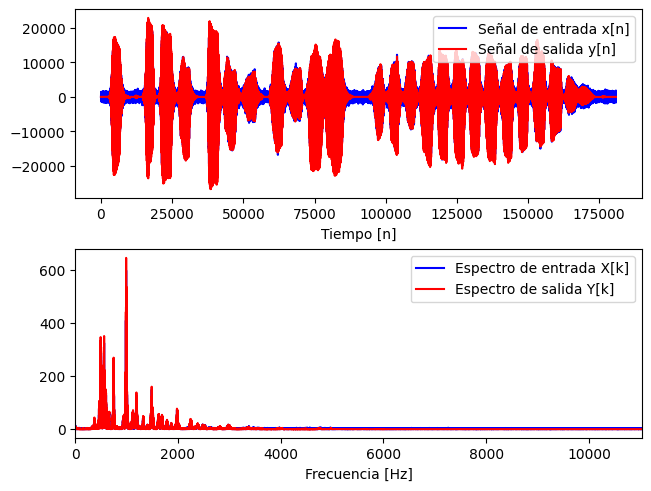

In [2]:
#Ejemplo 8.2. Aplicación de la Convolución Rápida en denoising 
#
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, ifft

def denoising(x, N, umbral):
    n = 0
    y = np.zeros(len(x)) # Condiciones iniciales cero
    Nx = int(N/2) 
    Nstep = int(N/4)
    while(n+N < len(x)):         
        xi = x[n:n+Nx]  #Captura N/2 datos con traslape     
        # Enventana, completa con ceros y calcula FFT
        Xk = fft(xi*np.hamming(Nx), N)      	
        # Calcula la respuesta en frecuencia 
        Xkmag = np.abs(Xk)     
        Hk = (Xkmag > umbral) 
        #Filtra                 
        yi = np.real( ifft(Xk*Hk) )   
        #Realiza la adición de los bloques     
        y[n:n+N] = y[n:n+N] + yi     
        n = n+Nstep #Traslape 50%
    return y


#Carga un archivo externo WAV
fs, xn = wavfile.read('cancion_ruido.wav')

#Realiza denoising
y = denoising(xn, 1024, 30000)

# Guarda la señal de salida en un archivo .wav
wavfile.write("cancion_filtrada2.wav", fs, y.astype(np.int16))

#Grafica las señales y sus espectros
fig, axs = plt.subplots(2,1,layout='constrained')

axs[0].plot(xn, 'b', label='Señal de entrada x[n]')
axs[0].plot(y,'r', label='Señal de salida y[n]')
axs[0].set_xlabel('Tiempo [n]')
axs[0].legend()
Xk = fft(xn)
Yk = fft(y)
f = fs*np.arange(0,len(Xk)).astype(float)/len(Xk)
axs[1].plot(f, np.abs(Xk)/len(Xk), 'b', label='Espectro de entrada X[k]')
axs[1].plot(f, np.abs(Yk)/len(Yk), 'r', label='Espectro de salida Y[k]')
axs[1].set_xlabel('Frecuencia [Hz]')
axs[1].set(xlim=(0,fs/4))
axs[1].legend()
plt.show()


El método antes descrito puede presentar un efecto conocido con el nombre de ruido musical, sin embargo, su análisis y forma de reducción están por fuera de este documento y se sugiere consultar las referencias. 

Una implementación en lenguaje C de esta técnica se puede consultar en https://github.com/jimarinh/SimDSP-Denoising/, la cual fue creada para correr sobre un dispositivo móvil basado en Android.  

### Para Reflexionar

* En el Ejemplo 8.2 se emplea una ventana de Hamming para introducir un suavizado a los bloques de entrada que permitan reducir el ruido musical. Modifique el ejemplo, eliminando la ventana de Hamming, y escuche el audio de salida. Esto le dará una idea de lo que es el ruido musical y cómo las discontinuidades entre bloques lo generan.

* La regla de _denoising_ implementada en el Ejemplo 8.2 se llama de umbral fuerte (_hard threshold_) porque hace cero todas las componentes que están por debajo del umbral y deja intactas aquellas por encima del umbral. Eso puede generar discontinuidades que generan artefactos que pueden ser perceptibles para el usuario. Una forma de solucionar el problema es usar una regla de _denoising_ de umbral suave (_soft threshold_) dada por la expresión: 

$$H_{soft}(\Omega)=\begin{cases}
(|X(\Omega)|-\Delta)e^{j\angle{X(\Omega)}} & Si\,\left|X(\Omega)\right|>\Delta\\
0 & Si\,\left|X(\Omega)\right|\leq\Delta
\end{cases}$$

* Modifique el Ejemplo 8.2 para incluir la regla de umbral suave.

## 8.3. Correlación Cruzada

Otra de las aplicaciones de la convolución rápida es el cálculo de la **correlación cruzada** y la **auto-correlación** que se explicará en la siguiente sección.

La **correlación cruzada** es una operación que permite determinar el grado de similitud entre dos señales. Esta operación, similar a la convolución, es usada en el reconocimiento de patrones, en comunicaciones para la identificación de los símbolos binarios, en radares y sonares para estimar el retardo de una señal, entre otras aplicaciones. 

La correlación cruzada permite diezmar los efectos del ruido aditivo que se añaden a una señal, permitiendo centrarse únicamente en los aspectos relevantes de la señal. Por ejemplo, en una aplicación de sonar, la señal recibida $y[n]$ corresponde a una versión desplazada en el tiempo de la señal transmitida, $x[n]$, más un ruido, $w[n]$, que adiciona el medio de transmisión, es decir, $$y[n]=x[n-D]+w[n]$$

![Radar](../img/cap8_radar.png)

Puesto que en esta aplicación $x[n]$ y $y[n]$ provienen de la misma fuente, la correlación cruzada permite estimar el valor del retardo en el tiempo, $D$. Asimismo, como el ruido $w[n]$ no está correlacionado con la señal $x[n]$, este efecto será eliminado al analizar la señal. La correlación cruzada se representa por $r_{xy}$ y se define como:

$$r_{xy}[l]=\sum_{n=-\infty}^{\infty}x[n]\,y[n+l]\,\,\,\,\,l=0,\pm1,\pm2,\pm3,...$$

$$r_{yx}[l]=\sum_{n=-\infty}^{\infty}x[n+l]\,y[n]\,\,\,\,\,l=0,\pm1,\pm2,\pm3,...$$

donde $l$ representa el desplazamiento en el tiempo o retardo entre ambas señales. Los ordenes de los índices $xy$ indican que la secuencia $x[n]$ no se desplaza, mientras que la secuencia $y[n]$ está desplazada $l$ muestras a la derecha. Esta operación no es conmutativa, así que si se calcula $r_{yx}$, la señal desplazada es $x[n]$ y este nuevo resultado está relacionado con $r_{xy}$ mediante:

$$r_{yx}[l]=r_{xy}[-l]$$

es decir, se obtiene la versión reflejada de la correlación cruzada $r_{xy}$.

Si comparamos las expresiones de la correlación cruzada y la convolución, podemos notar que la convolución involucra las operaciones de reflexión, desplazamiento y multiplicación-acumulación sobre todos los términos, en cambio para la correlación cruzada, no se realiza reflexión, así que por medio del algoritmo de la convolución rápida se puede calcular la correlación cruzada si se refleja la señal $y[n]$:

$$r_{xy}[l]=x[l]\star y[-l]$$

Aplicando las propiedades de la transformada de Fourier, se tiene que la reflexión de $y[-l]$ se transforma en la compleja conjugada de su espectro, facilitando el cálculo a través de la convolución rápida:

$$r_{xy}[l]=\mathcal{F}^{-1}\left\{ \mathcal{F}\left\{ x[l]\right\} \mathcal{F}\left\{ y[l]\right\} ^{*}\right\} $$

En el siguiente ejemplo, se muestra la aplicación de este principio en una aplicación de sonar. 

Desplazamiento estimado: 100


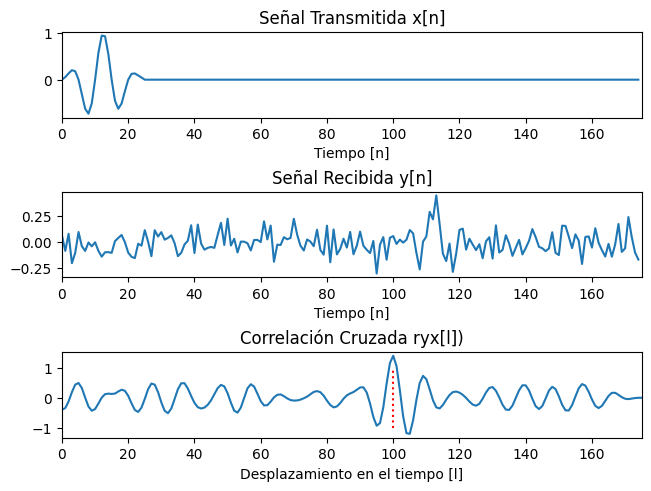

In [3]:
# Ejemplo 8.3 - Aplicación de la correlación cruzada y convolución rápida en una aplicación de sonar
#
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

# Simula la señal transmitida
t = np.arange(0,5*np.pi,np.pi/5)
x = np.sin(t) * np.hamming(len(t))

# Simula la señal recibida, asumiendo un desplazamiento D e incluyendo ruido aditivo
D = 100
yD = np.concatenate([np.zeros(D), x, np.zeros(50)])
y = 0.3*yD + np.random.normal(0, 0.1, len(yD))

# Calcula la correlación cruzada ryx usando convolución rápida y realizando zeropadding
Xk = fft(x, 512)
Yk = fft(y, 512)
ryx = np.real(ifft(np.conj(Xk)*Yk))

# Calcula el vector de desplazamientos l. 
lags = np.arange(0,len(ryx)) 

# Busca el punto máximo de la correlación cruzada
Dest = np.argmax(np.real(ryx))
print(f'Desplazamiento estimado: {Dest}')

fig, axs = plt.subplots(3,1,layout='constrained')
axs[0].plot(np.concatenate([x,np.zeros(len(y)-len(x))]))
axs[0].set_xlabel('Tiempo [n]')
axs[0].set_title('Señal Transmitida x[n]')
axs[0].set(xlim=(0,len(y)))

axs[1].plot(y)
axs[1].set_xlabel('Tiempo [n]')
axs[1].set_title('Señal Recibida y[n]')
axs[1].set(xlim=(0,len(y)))

axs[2].plot(lags,ryx)
axs[2].plot([Dest,Dest],[-1,1],'r:')
axs[2].set_xlabel('Desplazamiento en el tiempo [l]')
axs[2].set_title('Correlación Cruzada ryx[l])')
axs[2].set(xlim=(0,len(y)))
plt.show()

Nótese que debido al ruido, en la señal recibida es casi imposible detectar el desplazamiento de la señal, pero en la correlación cruzada, $r_{yx}[l]$, es fácil detectar la ubicación, $D$, pues esta corresponde al punto $l$ donde se presenta el máximo valor de la correlación cruzada entre las dos señales. 

## 8.4. Autocorrelación

Si $y[n]=x[n]$, las expresiones de la correlación cruzada se denominan **autocorrelación** y adquieren la forma:

$$r_{xx}[l]=\sum_{n=-\infty}^{\infty}x[n]\,x[n+l]\,\,\,\,\,l=0,\pm1,\pm2,\pm3,...$$

A diferencia de la correlación cruzada, que sirve para la medir la similitud entre dos señales, la función de autocorrelación mide la dependencia de la muestra $x[n]$ de una señal con sus instantes de tiempo anteriores. Puede notarse que el valor de la autocorrelación $r_{xx}[0]$ corresponde a la energía de la señal, que a su vez es el valor máximo que puede tomar la autocorrelación:

$$\left|r_{xx}[l]\right|\leq r_{xx}[0]=E_{_{x}}$$

Otra importante propiedad de la autocorrelación que se deduce de su expresión matemática, es que se trata de una función con simetría par. Por otro lado, para señales periódicas con período $N$, la autocorrelación adquiere la forma:

$$r_{xx}[l]=\frac{1}{N}\sum_{n=0}^{N-1}x[n]\,x[n+l]\,\,\,\,\,l=0,\pm1,\pm2,\pm3,...$$

Es importante anotar que una de las principales aplicaciones de la autocorrelación, que se deriva de la expresión anterior, es la identificación de la periodicidad de una señal inmersa en el ruido. Supongamos por ejemplo que tenemos una señal periódica $x[n]$ a la cual se le ha añadido un ruido $w[n]$. La autocorrelación de la señal contaminada será:

$$r_{yy}[l]=\frac{1}{N}\sum_{n=0}^{N-1}y[n]\,y[n+l]=\frac{1}{N}\sum_{n=0}^{N-1}(x[n]+w[n])(x[n+l]+w[n+l])=$$

$$=\frac{1}{N}\left\{ \sum_{n=0}^{N-1}x[n]x[n+l]+\sum_{n=0}^{N-1}x[n]w[n+l]+\sum_{n=0}^{N-1}w[n]x[n+l]+\sum_{n=0}^{N-1}w[n]w[n+l]\right\}$$ 

$$=r_{xx}[l]+r_{xw}[l]+r_{wx}[l]+r_{ww}[l]$$

pero como el ruido y la señal son independientes entre sí, las correlaciones cruzadas entre el ruido y la señal ($r_{xw}$ y $r_{wx}$) son cero, es decir, 

$$r_{yy}[l]=r_{xx}[l]+r_{ww}[l]$$

Como la autocorrelación del ruido, $r_{ww}$, se trata generalmente de una función delta o tiene un decaimiento rápido hacia cero, la autocorrelación de la señal contaminada $y[n]$ exhibirá máximos en los desplazamientos $l$ correspondientes al período de la señal original como se muestra en el siguiente ejemplo.

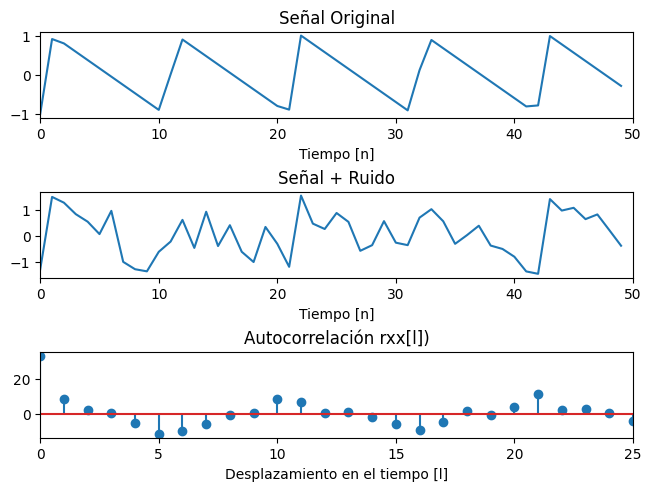

In [4]:
# Ejemplo 8.4 - Aplicación de la autocorrelación y convolución rápida
#               para determinar el periodo de una señal
#
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy.fft import fft, ifft

# Crea una señal periódica libre de ruido
t = np.arange(0,30,0.6)
xsr = sig.sawtooth(t,0.1)

# Incluye ruido aditivo a la señal periódica
w = np.random.normal(0, 0.5, len(xsr))
x = xsr + w

# Calcula la autocorrelación usando convolución rápida y realizando zeropadding
Xk = fft(x, 512)
rxx = np.real(ifft(np.abs(Xk)**2))
lags = np.arange(0,len(rxx))

# Grafica la señal original, la señal contaminada con ruido y la autocorrelación
fig, axs = plt.subplots(3,1,layout='constrained')
axs[0].plot(xsr)
axs[0].set_xlabel('Tiempo [n]')
axs[0].set_title('Señal Original')
axs[0].set(xlim=(0,len(x)))

axs[1].plot(x)
axs[1].set_xlabel('Tiempo [n]')
axs[1].set_title('Señal + Ruido')
axs[1].set(xlim=(0,len(x)))

axs[2].stem(lags,rxx)
axs[2].set_xlabel('Desplazamiento en el tiempo [l]')
axs[2].set_title('Autocorrelación rxx[l])')
axs[2].set(xlim=(0,25))
plt.show()

Por lo tanto, en el citado ejemplo se puede determinar que el período de la señal es 11. Nótese también que la autocorrelación evaluada en $l=0$ adquiere su valor máximo el cual es igual a 

$$r_{yy}[0]=E_{x}+r_{ww}[0]$$

Además, en el código anterior se ha usado la propiedad de que

$$r_{xx}[l]=\mathcal{F}^{-1}\left\{ \mathcal{F}\left\{ x[l]\right\} \mathcal{F}\left\{ x[l]\right\} ^{*}\right\} = \mathcal{F}^{-1}\left\{ |\mathcal{F}\left\{ x[l]\right\}|^{2}\right\} $$


### 8.4.1. Correlaciones Normalizadas

Por conveniencia, para efectos prácticos, las correlaciones cruzada y autocorrelación se prefieren normalizar a sus valores máximos, de esta forma, se definen la **correlación cruzada normaliza** y la **autocorrelación normalizada** como:

$$\rho_{xy}[l]=\frac{r_{xy}[l]}{\sqrt{r_{xx[0]}r_{yy[0]}}}=\frac{r_{xy}[l]}{\sqrt{E_{x}E_{y}}}$$

$$\rho_{xx}[l]=\frac{r_{xx}[l]}{r_{xx[0]}}=\frac{r_{xx}[l]}{E_{x}}$$

cuyos valores se encuentran en los rangos 

$$-1\leq\rho_{xx}[l]\leq1$$ 

$$-1\leq\rho_{xy}[l]\leq1$$

De esta forma, con estas funciones es más fácil estimar con precisión el valor del desplazamiento entre las dos señales a comparar, en el caso de la correlación cruzada, y así establecer su grado de similitud.

### Para Reflexionar

* Modifique el Ejemplo 8.4 para calcular la autocorrelación normalizada.

* Como se indicó en la secciones anteriores, una de las aplicaciones de la autocorrelación es la identificación del periodo de una señal, pero esta identificación depende de si el ruido de fondo es periódico o no. Para analizar el efecto sobre la autocorrelación del ruido periódico modifique el programa del Ejemplo 8.4 para cargar una señal de electrocardiograma (ECG) que fue extraída de la base de datos ECG-ID de Physionet (https://physionet.org/content/ecgiddb/1.0.0/). Esta señal fue muestreada a $f_{s}=500Hz$ y el archivo tiene dos columnas. La primera columna es la señal sin ningún tipo de pre-procesamiento, donde el ruido de la red eléctrica de 50Hz está presente. La segunda columna es la señal después de aplicar un filtrado digital que elimina el ruido de la red eléctrica. 

    a) Para analizar la autocorrelación de la señal con ruido, use las siguientes sentencias para cargar el archivo y analizar la primer columna. Modifique el tamaño de la FFT del Ejemplo 8.4 para que sea mayor al tamaño de la señal original. ¿Cuánto mide el periodo de la señal, si emplea esta autocorrelación?

In [2]:
senal_ecg = np.load('senal_ecg.npy')
x = senal_ecg[:,0]

b) Para analizar la autocorrelación de la señal sin el ruido de la red eléctrica, modifique el Ejemplo 8.4 para procesar la segunda columna. Se recomienda cambiar el límite del eje x para la gráfica de la autocorrelación. ¿Cuánto mide el periodo de la señal, si emplea esta autocorrelación?